## Introduction

Proximal Policy Optimization (PPO) is a popular and reliable reinforcement learning algorithm, especially for continuous control tasks. It is based on ideas from an older method called Trust Region Policy Optimization (TRPO), which was original, but it simplifies things by using a clever trick (called a clipped objective) to keep the learning stable. This makes it easier to use and less tricky to tune, and most importantly, efficient for larger scale problems.

## How it works

Two-part system: PPO has two parts — one that decides what to do (the Actor) and one that judges how good the current situation is (the Critic). The Critic helps the Actor improve its decision-making over time.

Learning from its own actions: The agent gathers experience by trying things out with its current strategy. It then uses this experience to learn and get better.

Controlled updates: PPO makes sure that the agent doesn’t change its strategy too drastically in one step. It does this by applying a simple rule (called clipping) that limits how much the new strategy can differ from the old one. This helps the learning stay stable and reliable.

Efficient learning: PPO reuses the same batch of experience multiple times during training, which helps it learn faster and more efficiently compared to some older methods that would throw out data after just one use.

## Step-by-step (simplified)

1) Initialisation

    Setup the policy network (actor), value network (critic), hyperparameters (learning rates, epsilon ie clipping rates, etc)

2) Learning epoch

    In each loop, PPO does the following:
    
    1. The agent interacts with the environment using its current policy, collects a batch of trajectories (aka states, actions, rewards, next states, etc)
        
    2. Compute rewards-to-go, and advantages based on current value function
    
        - Rewards-to-go are the total rewards collected from a specific trajectory, which are needed as a component for advantage computation
        - Advantage measures how much better (or worse) an action taken in a state is compared to the average action the policy would take.
        
    3. Learn from the experience (repeated several times) in order to optimise the policy, which includes the following steps:
    
        - Check how much the new policy differs from the current one (used to collect trajectories), applies a clipping rule to prevent too much change
        - Updates both the actor and critic using gradient descent
   
    4. Repeat until convergence

## Common use cases

Robots: Helping simulated robots walk, move, and handle objects.

Video Games: Training AI to play very complex games, such as Dota 2 (OpenAI Dota 2!)

Improving AI Assistants: Fine-tuning language models (like ChatGPT) based on human feedback (Reinforcement Learning with Human Feedback) so they give better answers.

General baseline: Often used as a strong, reliable starting point when trying out new AI ideas.

## Reinforcement Learning with Human Feedback (RLHF)

This is most likely the most industry relevant use case for PPO in recent times. Large Language Models (LLMs) are trained on massive amounts of text data, but this does not guarantee that their output is desirable to their users. RLHF helps to align the output of these LLMs with human preferences, and the key reasons are as follows:

- Stability: As fine-tuning LLMs is computationally expensive, it is important to be able to do so stably while avoiding performance drift.
- Sample efficiency: Having multiple epochs per data batch makes better use of the expensive rollouts (generating text and getting RM scores) when compared to single-update methods.
- Simplicity & Scalability: It is easier to implement and scale across distributed systems as compared to TRPO, its predecessor.


## RLHF Step-by-step (simplified)

This is done usually in a 3-step process:

1. Supervised Fine-tuning (SF)
    - Fine-tune a pretrained LLM on a small dataset of prompt-response pairs curated by humans to steer the LLM towards the desired types of output.
2. Reward Model (RM) Training
    - Take prompts and generate multiple responses using the SF model.
    - Human labelers rank these responses based on their preferences.
    - Train a separate model (often another LLM) to predict these human preference scores. Input is a prompt-response pair, output is a scalar reward signal.
3. RL Fine-tuning
    -   With the post-SF model as the initial policy, further fine-tune it using PPO.
    -   Policy here means the LLM itself, defining the probability distribution over the next token given the context.
    -   At the end of generating a response, the RM provides a scalar reward indicating the predicted quality/preference for that entire response.
    -   PPO uses the experience (prompt, generated response, RM reward) to update the LLM's (actor's) parameters to maximise the expected reward from the RM.

One important thing to note is that the process of fine-tuning any pretrained model may cause it to drift away from its original pretrained capabilities. RLHF thus has a crucial addition of adding a penalty to the PPO objective, preventing it from overfitting too much during the RL fine-tuning process.

## Challenges of RLHF implementation

1. Reward Model Quality: Heavily reliant on having a reward model that reflects true human preferences.
2. Reward Hacking: The LLM might simply exploit the reward model to get high scores without improvements to output quality.
3. Computational Cost: RLHF is extremely computationally intensive.
4. Hyperparameter Tuning: Requires careful tuning of both PPO and RLHF-specific parameters.

## Basic Implementation of PPO in Pytorch

This is an example of how PPO works with the classic cartpole problem in Pytorch (as both the Actor and Critics are MLPs), along with the appropriate logging as well as a visual animated showcase of the agent.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable
import copy # Needed for storing old policy network parameters
import gymnasium as gym
from celluloid import Camera
from IPython.display import HTML
import os

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
seed = 77
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Using device: cuda


In [2]:
# Define the Policy Network (Actor)
class PolicyNetwork(nn.Module):
    """ MLP Actor network for PPO """
    def __init__(self, n_observations: int, n_actions: int):
        super(PolicyNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x: torch.Tensor) -> Categorical:
        """
        Forward pass, returns a Categorical distribution.
        """
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)
        if x.dim() == 1:
            x = x.unsqueeze(0)
            
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        action_logits = self.layer3(x)
        return Categorical(logits=action_logits)

# Define the Value Network (Critic)
class ValueNetwork(nn.Module):
    """ MLP Critic network for PPO """
    def __init__(self, n_observations: int):
        super(ValueNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass, returns the estimated state value.
        """
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)
        if x.dim() == 1:
            x = x.unsqueeze(0)
            
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        state_value = self.layer3(x)
        return state_value

# Define the compute_gae function that's currently missing
def compute_gae(rewards: torch.Tensor, 
               values: torch.Tensor, 
               next_values: torch.Tensor, 
               dones: torch.Tensor, 
               gamma: float, 
               lambda_gae: float, 
               standardize: bool = True) -> torch.Tensor:
    """
    Computes Generalized Advantage Estimation (GAE).
    """
    advantages = torch.zeros_like(rewards)
    last_advantage = 0.0

    for t in reversed(range(len(rewards))):
        mask = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_values[t] * mask - values[t]
        advantages[t] = delta + gamma * lambda_gae * last_advantage * mask
        last_advantage = advantages[t]

    if standardize:
        mean_adv = torch.mean(advantages)
        std_adv = torch.std(advantages) + 1e-8
        advantages = (advantages - mean_adv) / std_adv
        
    return advantages

def update_ppo(actor: PolicyNetwork,
               critic: ValueNetwork,
               actor_optimizer: optim.Optimizer,
               critic_optimizer: optim.Optimizer,
               states: torch.Tensor,
               actions: torch.Tensor,
               log_probs_old: torch.Tensor,
               advantages: torch.Tensor,
               returns_to_go: torch.Tensor,
               ppo_epochs: int,
               ppo_clip_epsilon: float,
               value_loss_coeff: float,
               entropy_coeff: float) -> Tuple[float, float, float]: # Return avg losses
    """
    Performs the PPO update for multiple epochs over the collected batch.

    Parameters:
    - actor, critic: The networks.
    - actor_optimizer, critic_optimizer: The optimizers.
    - states, actions, log_probs_old, advantages, returns_to_go: Batch data tensors.
    - ppo_epochs (int): Number of optimization epochs.
    - ppo_clip_epsilon (float): Clipping parameter epsilon.
    - value_loss_coeff (float): Coefficient for the value loss.
    - entropy_coeff (float): Coefficient for the entropy bonus.

    Returns:
    - Tuple[float, float, float]: Average policy loss, value loss, and entropy over the epochs.
    """
    total_policy_loss = 0.0
    total_value_loss = 0.0
    total_entropy = 0.0

    # Detach advantages and old log probs - they are treated as constants during the update
    advantages = advantages.detach()
    log_probs_old = log_probs_old.detach()
    returns_to_go = returns_to_go.detach()

    for _ in range(ppo_epochs):
        # --- Actor (Policy) Update --- 
        # Evaluate current policy
        policy_dist = actor(states)
        log_probs_new = policy_dist.log_prob(actions)
        entropy = policy_dist.entropy().mean() # Entropy for exploration bonus
        
        # Calculate ratio r_t(theta)
        ratio = torch.exp(log_probs_new - log_probs_old)
        
        # Calculate surrogate objectives
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1.0 - ppo_clip_epsilon, 1.0 + ppo_clip_epsilon) * advantages
        
        # PPO Clipped Policy Loss (negative because optimizer minimizes)
        # We add the entropy bonus (maximize entropy -> minimize negative entropy)
        policy_loss = -torch.min(surr1, surr2).mean() - entropy_coeff * entropy
        
        # Optimize the actor
        actor_optimizer.zero_grad()
        policy_loss.backward()
        actor_optimizer.step()
        
        # --- Critic (Value) Update --- 
        # Predict values
        values_pred = critic(states).squeeze()
        
        # Value loss (MSE)
        value_loss = F.mse_loss(values_pred, returns_to_go)
        
        # Optimize the critic
        critic_optimizer.zero_grad()
        # Scale value loss before backward pass
        (value_loss_coeff * value_loss).backward()
        critic_optimizer.step()
        
        # Accumulate losses for logging
        total_policy_loss += policy_loss.item() # Log negative clipped objective + entropy bonus
        total_value_loss += value_loss.item()
        total_entropy += entropy.item()
        
    # Calculate average losses over the epochs
    avg_policy_loss = total_policy_loss / ppo_epochs
    avg_value_loss = total_value_loss / ppo_epochs
    avg_entropy = total_entropy / ppo_epochs
    
    return avg_policy_loss, avg_value_loss, avg_entropy

In [3]:
# Create the CartPole environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [4]:
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

# Initialize policy and value networks
actor = PolicyNetwork(n_observations, n_actions).to(device)
critic = ValueNetwork(n_observations).to(device)

In [5]:
# Optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=3e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

In [6]:
# PPO hyperparameters
gamma = 0.99 # Discount factor
lambda_gae = 0.95 # GAE lambda parameter
ppo_epochs = 4 # Number of optimization epochs per iteration
ppo_clip_epsilon = 0.2 # PPO clipping epsilon
value_loss_coeff = 0.5 # Coefficient for value loss
entropy_coeff = 0.01 # Coefficient for entropy bonus
batch_size = 2048
total_updates = 50
model_dir = "./ppo_cartpole_models"
os.makedirs(model_dir, exist_ok=True)

# Optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=3e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

In [7]:
# PPO loop
def collect_trajectories(env, actor, critic, batch_size):
    states, actions, rewards, dones = [], [], [], []
    log_probs, values, next_values = [], [], []
    episode_reward = 0
    obs, _ = env.reset()
    done = False
    steps = 0

    while steps < batch_size:
        state_tensor = torch.tensor(obs, dtype=torch.float32, device=device)
        with torch.no_grad():
            dist = actor(state_tensor)
            value = critic(state_tensor)

        action = dist.sample()
        log_prob = dist.log_prob(action)

        next_obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        episode_reward += reward

        states.append(obs)
        actions.append(action.item())
        rewards.append(reward)
        dones.append(done)
        log_probs.append(log_prob.item())
        values.append(value.item())

        obs = next_obs
        steps += 1

        if done:
            episode_rewards.append(episode_reward)
            obs, _ = env.reset()
            episode_reward = 0
            done = False

    # Bootstrap values
    for i in range(len(states)):
        s = torch.tensor(states[i], dtype=torch.float32, device=device)
        with torch.no_grad():
            next_v = critic(s).item()
        next_values.append(next_v)

    # Convert to tensors
    states = torch.tensor(states, dtype=torch.float32, device=device)
    actions = torch.tensor(actions, dtype=torch.int64, device=device)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
    dones = torch.tensor(dones, dtype=torch.float32, device=device)
    log_probs_old = torch.tensor(log_probs, dtype=torch.float32, device=device)
    values = torch.tensor(values, dtype=torch.float32, device=device)
    next_values = torch.tensor(next_values, dtype=torch.float32, device=device)

    # Compute advantages and returns
    advantages = compute_gae(rewards, values, next_values, dones, gamma, lambda_gae)
    returns_to_go = advantages + values

    return states, actions, log_probs_old, advantages, returns_to_go

episode_rewards = []

In [8]:
# Logging variables
log = {}
for item in ["update", "rewards","policy_loss","value_loss","entropy"]:
    log[item] = []


# Main training loop
for update in range(1, total_updates + 1):
    states, actions, log_probs_old, advantages, returns_to_go = collect_trajectories(
        env, actor, critic, batch_size
    )

    policy_loss, value_loss, entropy = update_ppo(
        actor, critic, actor_optimizer, critic_optimizer,
        states, actions, log_probs_old, advantages, returns_to_go,
        ppo_epochs, ppo_clip_epsilon, value_loss_coeff, entropy_coeff
    )

    avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
    log["update"].append(update)
    log["rewards"].append(avg_reward)
    log["policy_loss"].append(policy_loss)
    log["value_loss"].append(value_loss)
    log["entropy"].append(entropy)
    print(f"Update {update:03d} | Reward: {avg_reward:.2f} | Policy Loss: {policy_loss:.3f} | Value Loss: {value_loss:.3f} | Entropy: {entropy:.3f}")

    # Save models
    if update % 50 == 0 or update == total_updates:
        torch.save(actor.state_dict(), os.path.join(model_dir, f"actor_update{update}.pt"))
        torch.save(critic.state_dict(), os.path.join(model_dir, f"critic_update{update}.pt"))

C:\Users\wtan0\AppData\Local\Temp\ipykernel_13940\1562674605.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states = torch.tensor(states, dtype=torch.float32, device=device)


Update 001 | Reward: 23.60 | Policy Loss: -0.009 | Value Loss: 0.946 | Entropy: 0.691
Update 002 | Reward: 15.40 | Policy Loss: -0.009 | Value Loss: 0.952 | Entropy: 0.690
Update 003 | Reward: 19.20 | Policy Loss: -0.009 | Value Loss: 0.968 | Entropy: 0.686
Update 004 | Reward: 25.00 | Policy Loss: -0.009 | Value Loss: 0.959 | Entropy: 0.684
Update 005 | Reward: 27.70 | Policy Loss: -0.009 | Value Loss: 0.961 | Entropy: 0.679
Update 006 | Reward: 27.90 | Policy Loss: -0.009 | Value Loss: 0.967 | Entropy: 0.674
Update 007 | Reward: 24.90 | Policy Loss: -0.008 | Value Loss: 0.962 | Entropy: 0.671
Update 008 | Reward: 35.00 | Policy Loss: -0.008 | Value Loss: 0.961 | Entropy: 0.665
Update 009 | Reward: 41.70 | Policy Loss: -0.008 | Value Loss: 0.960 | Entropy: 0.659
Update 010 | Reward: 38.30 | Policy Loss: -0.008 | Value Loss: 0.951 | Entropy: 0.659
Update 011 | Reward: 52.10 | Policy Loss: -0.008 | Value Loss: 0.954 | Entropy: 0.651
Update 012 | Reward: 32.20 | Policy Loss: -0.008 | Val

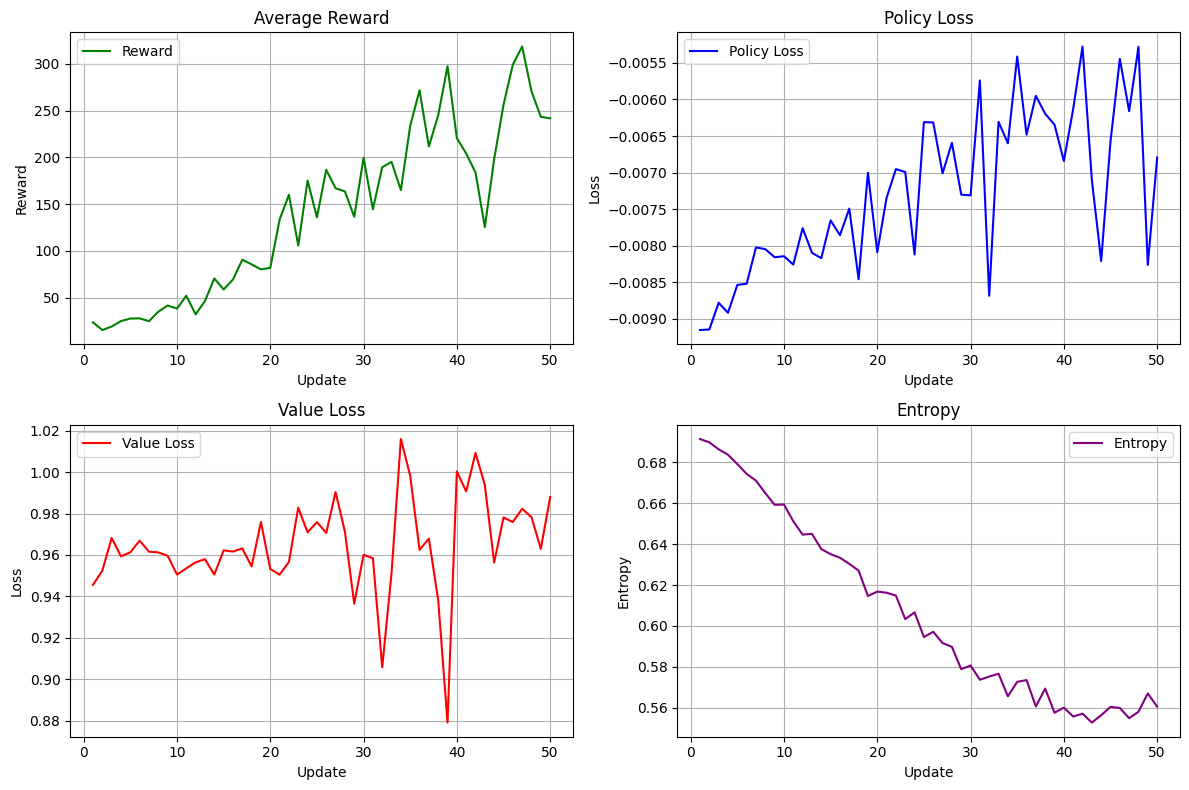

In [9]:
def plot_training_metrics(updates, rewards, policy_losses, value_losses, entropies):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Reward plot
    axs[0, 0].plot(updates, rewards, label="Reward", color="green")
    axs[0, 0].set_title("Average Reward")
    axs[0, 0].set_xlabel("Update")
    axs[0, 0].set_ylabel("Reward")

    # Policy loss plot
    axs[0, 1].plot(updates, policy_losses, label="Policy Loss", color="blue")
    axs[0, 1].set_title("Policy Loss")
    axs[0, 1].set_xlabel("Update")
    axs[0, 1].set_ylabel("Loss")

    # Value loss plot
    axs[1, 0].plot(updates, value_losses, label="Value Loss", color="red")
    axs[1, 0].set_title("Value Loss")
    axs[1, 0].set_xlabel("Update")
    axs[1, 0].set_ylabel("Loss")

    # Entropy plot
    axs[1, 1].plot(updates, entropies, label="Entropy", color="purple")
    axs[1, 1].set_title("Entropy")
    axs[1, 1].set_xlabel("Update")
    axs[1, 1].set_ylabel("Entropy")

    for ax in axs.flat:
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_training_metrics(log["update"],log["rewards"],log["policy_loss"],log["value_loss"],log["entropy"])

In [10]:
# Visual showcase of how the PPO agent has learnt to solve the cartpole problem

obs, _ = env.reset()
frames = []

# Collect frames
for _ in range(100):
    frame = env.render()
    frames.append(frame)
    obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device)
    with torch.no_grad():
        action = actor(obs_tensor).sample().item()
    obs, _, terminated, truncated, _ = env.step(action)

env.close()

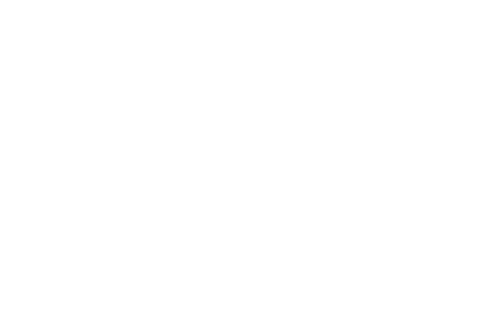

In [11]:
# Plot and animate with Celluloid
fig = plt.figure(figsize=(6, 4))
camera = Camera(fig)

for frame in frames:
    plt.imshow(frame)
    plt.axis("off")
    camera.snap()

# Create animation
animation = camera.animate(interval=10)

# Display animation directly
HTML(animation.to_jshtml())